# Support Vector Machine

These are some experiments with SVM. Here I test the 3 main SVC (Support Vector Classification) algorithms: Linear SVM, Nu-SVM and C-SVM. The N-SVM seems to be the best but we need more experiments.

This analysis is very simple. I shuffle my dataset and take $30\%$ of testing. I do this $M$ times and store each shuffled data set. Then I preform $M$ classifications and take the mean of thhe numer of miss-classified samples and corresponding variance.

This is only for a single cell (like Anabel did). I guess we should have to repeat this for all cells in the mesh.

In [129]:
# Import required packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math #


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.svm import LinearSVC, NuSVC, SVC

In [130]:
# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# Setup numpy options
np.set_printoptions(precision=3, suppress=True)

# Get the data
PT_data = pd.read_excel("PTResults_trimmed.xlsx")

### Training SVM

Here you can change the number of shuffles and test size. This will store the training and testing features and targets to be used for any algorithms you want.

In [131]:
## TRAINING SVM  ##

target = 0.617035028915481
X = PT_data.drop(target, axis=1) # Just preparing the data
y = PT_data[target]

training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

M = 1000 # number of shuffles
test_size = 30 # number of cells to be tested out of 100

#Splitting the data into training and testing and storing to reuze same seeds
# for the different algorithms
for i in range(M):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=test_size/100, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)
    
print(training_features.describe())

       Temperture[K]  AoA[o]  Mach  MVD[mum]  rho[kg/m3]
count           70.0    70.0  70.0      70.0        70.0
mean           250.1     5.7   0.6       0.0         0.8
std             11.2     3.2   0.1       0.0         0.3
min            233.2     0.1   0.3       0.0         0.4
25%            240.3     3.2   0.4       0.0         0.6
50%            249.5     6.3   0.6       0.0         0.8
75%            258.0     8.0   0.7       0.0         1.0
max            272.7     9.9   0.8       0.0         1.2


## Linear SVM

This uses the kernel $K(x,x') := \langle x, x'\rangle$. It's here just for funny. It gives very bad results...

In [132]:
# Linear Support Vector Classification
MSE_linear = 0
VarMSE_linear = 0
missclass = []
for i in range(M):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Linear SVC
    model = LinearSVC(random_state=0, tol=1e-5)
    model.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = model.predict(testing_features)
    
    #Get means and std
    MSE = mean_squared_error(prediction, testing_target)
    MSE_linear += MSE
    VarMSE_linear += MSE*MSE
    missclass.append(30*mean_squared_error(prediction, testing_target))
    
MSE_linear /= M
VarMSE_linear -= M*MSE_linear**2
VarMSE_linear /=(M-1)
count_linear = test_size*MSE_linear
countstd_linear = test_size*VarMSE_linear
print('Average number of miss classified cells out of ' + str(M) + ' shuffles: ' + 
      str(count_linear) + ' +- ' + str(countstd_linear))

Average number of miss classified cells out of 1000 shuffles: 7.364 +- 0.536119586253


## Nu-Support Vector Classification

See documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html

We start by choosing the kernel: 'rbf' or 'poly'. 
    - If 'rbf' is choosen then we can choose two parameters: $\nu$ and $\gamma$
    - If 'poly' or 'sigmoid' is choosen then we can choose three parameters: $\nu$, $\gamma$ and polynomial degree

The values of the parameters to be tested are in: nu_vector, gamma_vector and degree_vector. You may change these values if you want. Be carefull, for dregree > 3 things become slow for $\gamma > 0.01$.

The strategy to find to optimum is to save all combinations of parameters that give $<15\%$ misclassification with variance $<5\%$. To do so we start with kernel = 'rbf' to tune the gamma values. We will see that the kernel = 'poly' is the best. 

#### Classifier function

This is our personalised classifier that returns the mean squared error, the variance of the MSE and the number of misclassified shuffles

In [133]:
# Nu-Support Vector Classification
def mySVC_Nu(nu, kernel, gamma, degree=0):

    MSE_Nu = 0
    VarMSE_Nu = 0
    missclass = []
    for i in range(M):
        
        training_features = training_features_vector[i]
        testing_features = testing_features_vector[i]
        training_target = training_target_vector[i]
        testing_target = testing_target_vector[i]

        #Training with Nu-SVC
        model = NuSVC(nu = nu, kernel = kernel, degree=degree, gamma=gamma)
            
        model.fit(training_features, training_target)

        #Comparing prediction with testing values
        prediction = model.predict(testing_features)

        #Get means and std
        MSE = mean_squared_error(prediction, testing_target)
        MSE_Nu += MSE
        VarMSE_Nu += MSE*MSE
        missclass.append(30*mean_squared_error(prediction, testing_target))

    MSE_Nu /= M
    VarMSE_Nu -= M*MSE_Nu**2
    VarMSE_Nu /=(M-1)
#     count_Nu = test_size*MSE_Nu
#     countVar_Nu = test_size*VarMSE_Nu
           
    return MSE_Nu, VarMSE_Nu, missclass

### kernel = 'rbf'

In [134]:
nu_vector = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
gamma_vector = [0.0001, 0.001, 0.01, 0.1]



# kernel = 'rbf'
opt_rbf = []
n_simul = len(nu_vector)*len(gamma_vector)
count = 0
for i in range(len(nu_vector)):
    nu = nu_vector[i]
    for j in range(len(gamma_vector)):
        count += 1
        if count % 10 == 0:
            print('# simulations done ' + str(count) + '/' + str(n_simul))
        gamma = gamma_vector[j]
        MSE_Nu, VarMSE_Nu, missclass = mySVC_Nu(nu=nu, kernel = 'rbf', gamma=gamma, degree=0)
        if test_size*MSE_Nu/test_size < 0.15:
            opt_rbf.append([i,j])

print('candidate indices for optimal distributions')                
print(opt_rbf)            

# simulations done 10/28
# simulations done 20/28
candidate indices for optimal distributions
[]


### kernel = 'sigmoid'

In [135]:
nu_vector = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [0,1,2,3,4]

# counting how many simulations to be done
n_simul_sigm = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            n_simul_sigm += 1

print('number of simulations to be done ' + str(n_simul_sigm))


# kernel = 'poly'
opt_sigm = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_sigm))
            nu = nu_vector[i]
            MSE_Nu, VarMSE_Nu, missclass = mySVC_Nu(nu=nu, kernel = 'sigmoid', gamma=gamma, degree=degree)
            if test_size*MSE_Nu/test_size < 0.15:
                opt_sigm.append([i,j,k])

print('candidate indices for optimal distributions')                
print(opt_sigm)  

number of simulations to be done 135
# simulations done 20/135
# simulations done 40/135
# simulations done 60/135
# simulations done 80/135
# simulations done 100/135
# simulations done 120/135
candidate indices for optimal distributions
[]


### kernel = 'poly'

In [136]:
nu_vector = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [0,1,2,3,4]

# counting how many simulations to be done
n_simul_poly = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            n_simul_poly += 1

print('number of simulations to be done ' + str(n_simul_poly))


# kernel = 'poly'
opt_poly = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_poly))
            nu = nu_vector[i]
            MSE_Nu, VarMSE_Nu, missclass = mySVC_Nu(nu=nu, kernel = 'poly', gamma=gamma, degree=degree)
            if test_size*MSE_Nu/test_size < 0.15:
                opt_poly.append([i,j,k])


                
print()                
print('candidate indices for optimal distributions')                
print(opt_poly)            

number of simulations to be done 117
# simulations done 20/117
# simulations done 40/117
# simulations done 60/117
# simulations done 80/117
# simulations done 100/117

candidate indices for optimal distributions
[[3, 1, 3], [4, 1, 3], [2, 1, 4], [3, 1, 4], [4, 1, 4]]


Simulate once again the candidates for optimum to get the histograms

In [137]:
axes_vector = []
for i in range(len(opt_poly)):
    nu = nu_vector[opt_poly[i][0]]
    gamma = gamma_vector[opt_poly[i][1]]
    degree = degree_vector[opt_poly[i][2]]
    MSE_Nu, VarMSE_Nu, missclass = mySVC_Nu(nu, kernel = 'poly', gamma=gamma, degree=degree)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE_Nu) + r' +- ' + str(test_size*VarMSE_Nu) + r' with gamma = ' + str(gamma) + 
         r', degree ' + str(degree) + ' and nu = ' + str(nu))

Average # misclassified samples from 30 samples: 4.366 +- 0.148416549883 with gamma = 0.0001, degree 3 and nu = 0.25
Average # misclassified samples from 30 samples: 4.359 +- 0.149553520187 with gamma = 0.0001, degree 3 and nu = 0.3
Average # misclassified samples from 30 samples: 4.294 +- 0.166552018685 with gamma = 0.0001, degree 4 and nu = 0.2
Average # misclassified samples from 30 samples: 3.94 +- 0.111791791792 with gamma = 0.0001, degree 4 and nu = 0.25
Average # misclassified samples from 30 samples: 4.081 +- 0.148029329329 with gamma = 0.0001, degree 4 and nu = 0.3


Plotting histograms

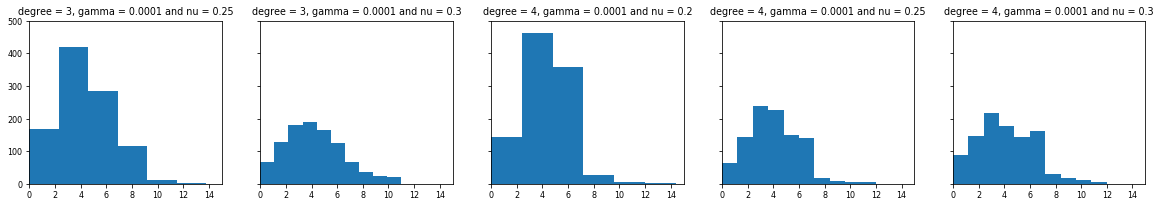

In [138]:
# Plotting for optimum
rows = 1
columns = len(axes_vector)
fig, ax = plt.subplots(rows, columns, figsize=(20,3), sharex='col', sharey='row')
plt.rcParams.update({'font.size': 8})


for j in range(columns):
    ax[j].hist(axes_vector[j], bins=10)
    ax[j].set_title('degree = ' + str(degree_vector[opt_poly[j][2]]) + ', gamma = ' + str (gamma_vector[opt_poly[j][1]]) \
                    + ' and nu = ' + str(nu_vector[opt_poly[j][0]]))
    ax[j].set_ylim(0,500)
    ax[j].set_xlim(0,15)

plt.show()

## C-Support Vector Classification

see documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

Same as for Nu-SVC (very little changes). Parameter $\nu$ becomes the parameter C.

YOU CAN USE THE PARAMETERS YOU WANT BUT IT IS VERY UNLIKELY THERE WILL BE A CANDIDATE FOR OPTIMAL DISTRIBUTION. The mean may get low but variance is too large

In [144]:
# C-Support Vector Classification
def mySVC(C, kernel, gamma, degree):  # changed the name of the function

    MSE_svc = 0
    VarMSE_svc = 0
    missclass = []
    for i in range(M):
        training_features = training_features_vector[i]
        testing_features = testing_features_vector[i]
        training_target = training_target_vector[i]
        testing_target = testing_target_vector[i]

        #Training with Nu-SVC
        model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
        model.fit(training_features, training_target)

        #Comparing prediction with testing values
        prediction = model.predict(testing_features)

        #Get means and std
        MSE = mean_squared_error(prediction, testing_target)
        MSE_svc += MSE
        VarMSE_svc += MSE*MSE
        missclass.append(30*mean_squared_error(prediction, testing_target))

    MSE_svc /= M
    VarMSE_svc -= M*MSE_svc**2
    VarMSE_svc/=(M-1)
    count_svc = test_size*MSE_svc
    countVar_svc = test_size*VarMSE_svc
    
           
    return MSE, VarMSE, missclass

### kernel = 'rbf'

In [160]:
C_vector = [0.2, 0.4, 0.8, 1, 2, 5, 10]
gamma_vector = [0.0001, 0.001, 0.01, 0.1]

# kernel = 'rbf'
opt_rbf = []
n_simul = len(C_vector)*len(gamma_vector)
count = 0
for i in range(len(C_vector)):
    C = C_vector[i]
    for j in range(len(gamma_vector)):
        count += 1
        if count % 10 == 0:
            print('# simulations done ' + str(count) + '/' + str(n_simul))
        gamma = gamma_vector[j]
        MSE, VarMSE, missclass = mySVC(C=C, kernel = 'rbf', gamma=gamma, degree=0) # changed mySVC
        if test_size*MSE/test_size < 0.15 and test_size*VarMSE/test_size < 0.05:
            opt_rbf.append([i,j])

print()
if len(opt_rbf) == 0: print('no condidates for optimal distributions')
else:        
    print('candidate indices for optimal distributions')
    print(opt_rbf)           

# simulations done 10/28
# simulations done 20/28
no condidates for optimal distributions


In [149]:
axes_vector = []
for i in range(len(opt_rbf)):
    C = C_vector[opt_rbf[i][0]]
    gamma = gamma_vector[opt_rbf[i][1]]
    MSE, VarMSE, missclass = mySVC(C, kernel = 'rbf', gamma=gamma, degree=0)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE) + r' +- ' + str(test_size*VarMSE) + r' with gamma = ' + str(gamma) + 
         r', degree ' + str(degree) + ' and C = ' + str(C))

### kernel = 'sigmoid'

In [150]:
C_vector = [0.2, 0.4, 0.8, 1, 2, 5, 10]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [0,1,2,3,4]

# counting how many simulations to be done
n_simul_sigm = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            n_simul_sigm += 1

print('number of simulations to be done ' + str(n_simul_sigm))


# kernel = 'sigmoid'
opt_sigm = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_sigm))
            nu = nu_vector[i]
            MSE, VarMSE, missclass = mySVC(C=C, kernel = 'sigmoid', gamma=gamma, degree=degree)
            if test_size*MSE/test_size < 0.15 and test_size*VarMSE/test_size < 0.05:
                opt_sigm.append([i,j,k])

print()
if len(opt_sigm == 0: print('no condidates for optimal distributions')
else:        
    print('candidate indices for optimal distributions')
    print(opt_sigm) 

number of simulations to be done 135
# simulations done 20/135
# simulations done 40/135
# simulations done 60/135
# simulations done 80/135
# simulations done 100/135
# simulations done 120/135
candidate indices for optimal distributions
[]


### kernel = 'poly'

In [158]:
C_vector = [0.2, 0.4, 0.8, 1, 2, 5, 10]
gamma_vector = [0.00001, 0.0001, 0.001]
degree_vector = [0,1,2,3,4]

# counting how many simulations to be done
n_simul_poly = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            n_simul_poly += 1

print('number of simulations to be done ' + str(n_simul_poly))


# kernel = 'poly'
opt_poly = []
count = 0
for k in range(len(degree_vector)):
    degree = degree_vector[k]
    for j in range(len(gamma_vector)):
        gamma = gamma_vector[j]
        if degree >= 2 and gamma >= 0.01: continue
        if degree >= 3 and gamma >= 0.001: continue
        for i in range(len(nu_vector)):
            count +=1
            if count % 20 == 0:
                print('# simulations done ' + str(count) + '/' + str(n_simul_poly))
            nu = nu_vector[i]
            MSE, VarMSE, missclass = mySVC(C=C, kernel = 'poly', gamma=gamma, degree=degree)
            if test_size*MSE/test_size < 0.15 and test_size*VarMSE/test_size < 0.05:
                opt_poly.append([i,j,k])


print()              
if len(opt_rbf) == 0: print('no condidates for optimal distributions')
else:        
    print('candidate indices for optimal distributions')
    print(opt_rbf) 

number of simulations to be done 117
# simulations done 20/117
# simulations done 40/117
# simulations done 60/117
# simulations done 80/117
# simulations done 100/117

candidate indices for optimal distributions
[]





Simulate once again the candidates for optimum to get the histograms

In [159]:
axes_vector = []
for i in range(len(opt_poly)):
    nu = nu_vector[opt_poly[i][0]]
    gamma = gamma_vector[opt_poly[i][1]]
    degree = degree_vector[opt_poly[i][2]]
    MSE, VarMSE, missclass = mySVC(C=C, kernel = 'poly', gamma=gamma, degree=degree)
    axes_vector.append(missclass)
    print(r'Average # misclassified samples from ' + str(test_size) + r' samples: ' + 
              str(test_size*MSE) + r' +- ' + str(test_size*VarMSE) + r' with gamma = ' + str(gamma) + 
         r', degree ' + str(degree) + ' and C = ' + str(C))

Plotting histograms